In [339]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt


In [340]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

C:\Users\serha\PycharmProjects\pythonProject\venv\lib\site-packages\malaya_speech\utils\featurization.py:38: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.mel_basis = librosa.filters.mel(


In [341]:
import soundfile as sf
import noisereduce as nr


y, sr = malaya_speech.load('naber.wav')
reduce_noise = nr.reduce_noise(y=y, sr=sr, prop_decrease= 1.1)
sf.write("naber.wav", reduce_noise, samplerate=sr)
len(y), sr

(342698, 16000)

In [342]:
from spectralcluster import RefinementOptions
from spectralcluster import ThresholdType
from spectralcluster import ICASSP2018_REFINEMENT_SEQUENCE
from spectralcluster import SpectralClusterer
clusterer = SpectralClusterer(
    min_clusters=1,
    max_clusters=100,
    refinement_options = RefinementOptions(
    gaussian_blur_sigma=2.5,
    p_percentile=0.95,
    thresholding_soft_multiplier=0.01,
    thresholding_type=ThresholdType.RowMax,
    refinement_sequence=ICASSP2018_REFINEMENT_SEQUENCE)
)


C:\Users\serha\PycharmProjects\pythonProject\venv\lib\site-packages\malaya_speech\utils\featurization.py:120: FutureWarning: Pass sr=16000, n_fft=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.mel_basis = librosa.filters.mel(


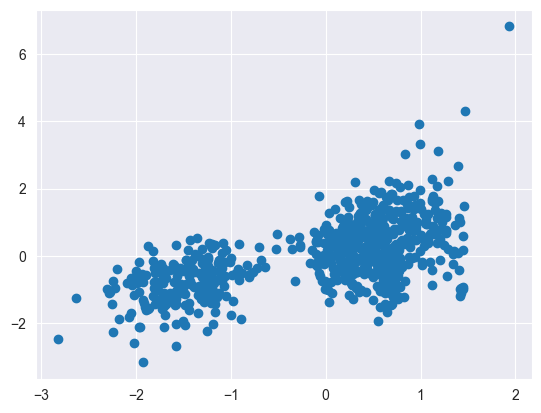

(714, 80)

In [343]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from numpy import random
featurizer = malaya_speech.featurization.STTFeaturizer(feature_type = 'log_mel_spectrogram',
                                                      frame_ms = 50, stride_ms = 30)
features = featurizer(y)
plt.scatter(features[:,0],features[:,1])
plt.show()
features.shape

In [344]:
from malaya_speech.utils.dist import l2_normalize

In [345]:
cluster_labels = clusterer.predict(l2_normalize(features))
frames = malaya_speech.arange.arange_frames(features, y, sr)
results = []
for no, result in enumerate(cluster_labels):
    results.append((frames[no], result))
grouped = malaya_speech.group.group_frames(results)

In [346]:
grouped

[(<malaya_speech.model.frame.Frame at 0x2dbd78767a0>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876e60>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd78756c0>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7874e20>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7875210>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876ec0>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876890>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7874d60>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd78771f0>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876c80>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7874430>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd78751e0>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876470>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876bf0>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7875a20>, 0),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876cb0>, 1),
 (<malaya_speech.model.frame.Frame at 0x2dbd7876a70>, 0),
 (<malaya_spee

In [347]:
import tensorflow_hub as hub
module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3')

In [348]:
# i think 60ms pretty ok
frames = malaya_speech.generator.frames(y, frame_duration_ms = 30)
len(frames)

714

In [349]:
from tqdm import tqdm

arrays = [f.array for f in frames]
embeddings = []
for i in tqdm(range(len(arrays))):
    e = module(arrays[i], sample_rate=16000)['embedding']
    embeddings.append(e)

100%|██████████| 714/714 [00:34<00:00, 20.78it/s]


In [350]:
concat = np.concatenate(embeddings, axis = 0)
concat.shape

(714, 512)

In [351]:
from spectralcluster import RefinementOptions
from spectralcluster import ThresholdType
from spectralcluster import ICASSP2018_REFINEMENT_SEQUENCE
from spectralcluster import SpectralClusterer
clusterer = SpectralClusterer(
    min_clusters=1,
    max_clusters=100,
    refinement_options = RefinementOptions(
    gaussian_blur_sigma=30,
    p_percentile=0.95,
    thresholding_soft_multiplier=0.01,
    thresholding_type=ThresholdType.RowMax,
    refinement_sequence=ICASSP2018_REFINEMENT_SEQUENCE)
)

In [352]:
cluster_labels = clusterer.predict(l2_normalize(concat))
frames = malaya_speech.arange.arange_frames(concat, y, sr)
results_trill = []
for no, result in enumerate(cluster_labels):
    results_trill.append((frames[no], result))
grouped_trill = malaya_speech.group.group_frames(results_trill)
grouped_trill

[(<malaya_speech.model.frame.Frame at 0x2dbccbd7910>, 0)]

C:\Users\serha\PycharmProjects\pythonProject\venv\lib\site-packages\malaya_speech\extra\visualization.py:168: RuntimeWarning: invalid value encountered in divide
  std = (a - np.min(a)) / (np.max(a) - np.min(a))
C:\Users\serha\PycharmProjects\pythonProject\venv\lib\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


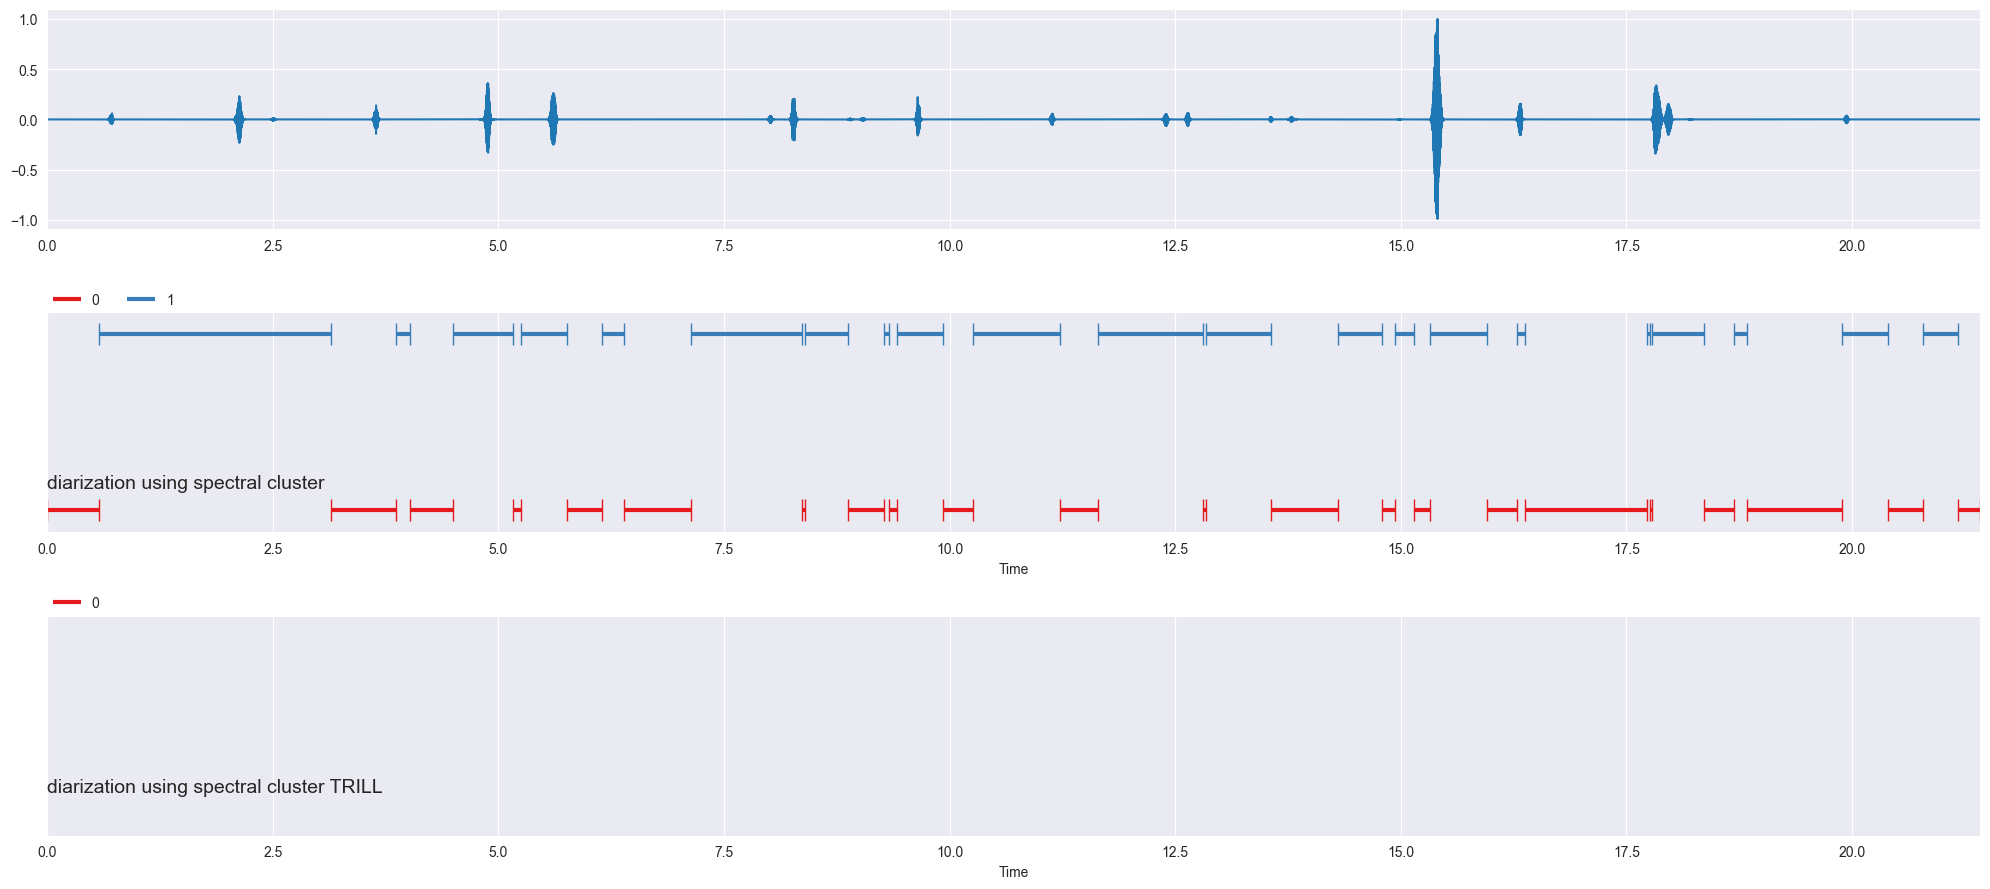

In [353]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
min_timestamp = min([i[0].timestamp for i in grouped])
max_timestamp = max([i[0].timestamp + i[0].duration for i in grouped])
ax[0].set_xlim((min_timestamp, max_timestamp))
ax[0].plot([i / sr for i in range(len(y))], y)
malaya_speech.extra.visualization.plot_classification(grouped,
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(grouped_trill,
                                                      'diarization using spectral cluster TRILL', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

In [377]:
import IPython.display as ipd

print(grouped[2] [0])
grouped[0][0].array
ipd.Audio(grouped[0][0].array, rate = sr)


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -3.15308213e-05, -3.15308213e-05, -3.15308213e-05])

In [355]:
import IPython.display as ipd

ipd.Audio(grouped[1][0].array, rate = sr)

In [356]:
import IPython.display as ipd

ipd.Audio(grouped[2][0].array, rate = sr)

In [357]:
import IPython.display as ipd

ipd.Audio(grouped[3][0].array, rate = sr)

In [358]:
import IPython.display as ipd

ipd.Audio(grouped[75][0].array, rate = sr)

IndexError: list index out of range

In [ ]:
import IPython.display as ipd

ipd.Audio(grouped[39][0].array, rate = sr)

In [ ]:
import IPython.display as ipd

ipd.Audio(grouped[6][0].array, rate = sr)

In [ ]:
ipd.Audio(grouped_trill[0][0].array, rate=sr)

In [388]:
import wave as wave
combine = 0
print(grouped.__len__())
for x in range(0, grouped.__len__(), 1):
    if grouped[x] [1] == 0:
      wave.Wave_write.writeframes(data=grouped[x][0])
    try:
        with wave.open('output-example4.wav', "rb") as infile:
            # get file data
            nchannels = infile.getnchannels()
            sampwidth = infile.getsampwidth()
            framerate = infile.getframerate()
            # set position in wave to start of segment
            infile.setpos(int(start * framerate))
            # extract data
            data = infile.readframes(grouped[x][0].Frame.duration)
    except wave.Error:
        pass

        try:
                # write the extracted data to a new file
            with wave.open('outputfile.wav', 'w') as outfile:
                    outfile.setnchannels(nchannels)
                    outfile.setsampwidth(sampwidth)
                    outfile.setframerate(framerate)
                    outfile.setnframes(int(len(data) / sampwidth))
                    outfile.writeframes(data)
        except wave.Error:
            pass
        infile.close()
        outfile.close()

        the_result_audio_file = AudioSegment.from_wav("outputfile.wav")

        combine = combine + the_result_audio_file
        combine.export("C:/Users/serha/PycharmProjects/pythonProject/combined.wav", format='wav')
print(combine)
# file to extract the snippet from


IndentationError: unexpected indent (1390973436.py, line 10)